# CNN Springfield

De los 49 posibles personajes escogí 13, porque son mis favoritos y porque si elegía más mi compu tardaba mucho y colab me cerraba la sesión.

Escogí a los siguientes 13 personajes: 

* Abuelo Simpson
* Apu
* Barney
* Jefe Gorgori
* Duff man
* Willie
* Homero
* Maggie
* Milhouse
* Flanders
* Nelson
* Otto
* Rafa

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import tensorflow as tf
from random import sample
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

print(tf.__version__)

TRAINING_PATH = 'simpsons_dataset/'
TEST_PATH = 'simpsons_testdataset/'

paths = ['abraham_grampa_simpson/',
          'apu_nahasapeemapetilon/',
          'barney_gumble/',
          'chief_wiggum/',
          'duff_man/',
          'groundskeeper_willie/',
          'homer_simpson/',
          'maggie_simpson/',
          'milhouse_van_houten/',
          'ned_flanders/',
          'nelson_muntz/',
          'otto_mann/',
          'ralph_wiggum/']

2.5.0


# Leyendo y visualizando las imágenes

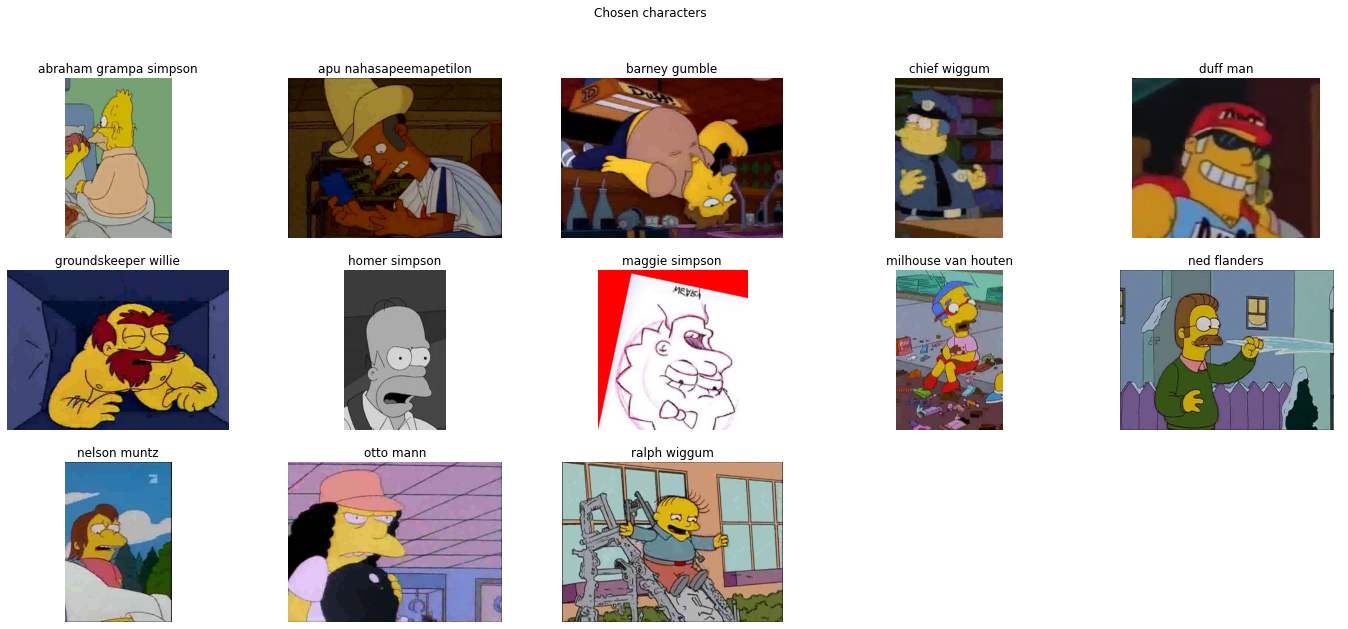

In [2]:
ROWS = 3
COLS = 5
path = 0
amount_images = np.zeros(len(paths))

fig, ax = plt.subplots(3, 5, figsize = (24, 10))
for i in range(ROWS):
    for j in range(COLS):
        pics = os.listdir(TRAINING_PATH + paths[path])
        amount_images[path] = len(pics)
        index = np.random.randint(len(pics))
        ax[i][j].imshow(Image.open(TRAINING_PATH + paths[path] + pics[index]))
        ax[i][j].axis('off')
        ax[i][j].set_title(' '.join(paths[path].split('_')).replace('/', ''))
        path += 1

        if (path > 12):
            break

fig.suptitle('Chosen characters')
ax[2][3].axis('off')
ax[2][4].axis('off')
plt.show()

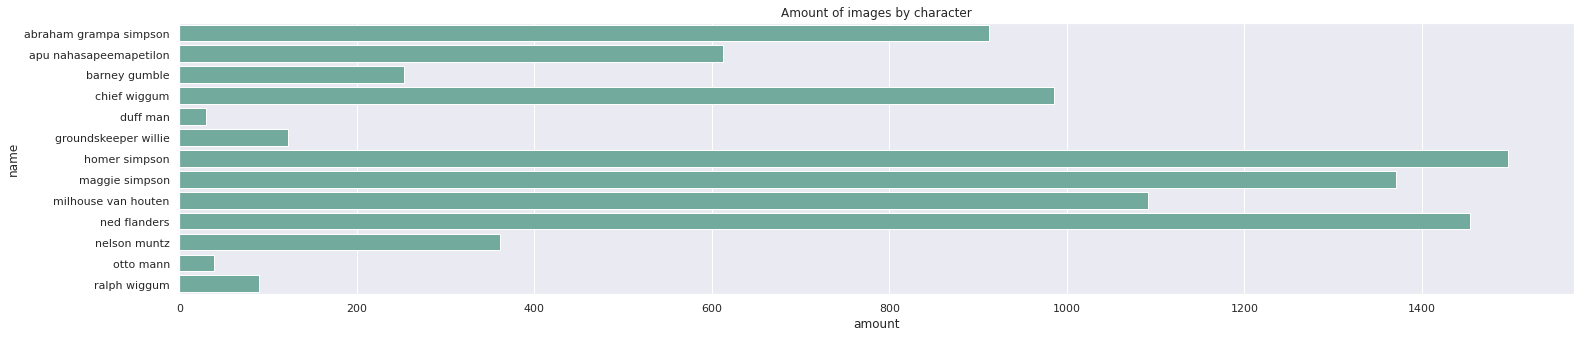

In [3]:
data = {
    'name' : [' '.join(path.split('_')).replace('/', '') for path in paths],
    'amount' : amount_images
}

df = pd.DataFrame(data)

sns.set(style="darkgrid")
plt.figure(figsize=(25, 5))

sns.barplot(
    x = 'amount', 
    y = 'name',
    data = df, 
    estimator = sum, 
    ci = None, 
    color = '#69b3a2').set_title('Amount of images by character');

Aquí podemos observar que se trata, claramente, de un problema desbalanceado, homero tiene más de 4000 imágenes, mientras que personajes como Otto o Duff Man no llegan ni a 250 imágenes. En estos casos lo ideal es conseguir más imágenes de estos último o, en su defecto, deshacerse de algunas imágenes de las clases que tienen más imágenes, en este caso Homero. Homero tiene una gran cantidad de imágenes, por lo que las reduciremos a 1500 imágenes.

En caso de que se haya corrido otra vez el notebook aquí dejo una imagen de la gráfica antes de eliminar imágenes de Homero.

<img src="homero muchos.png">

Una cosa más que haremos es ver cuántos canales diferentes tienen las imágenes de las carpetas cuyos paths están contenidos en el arreglo *paths*.

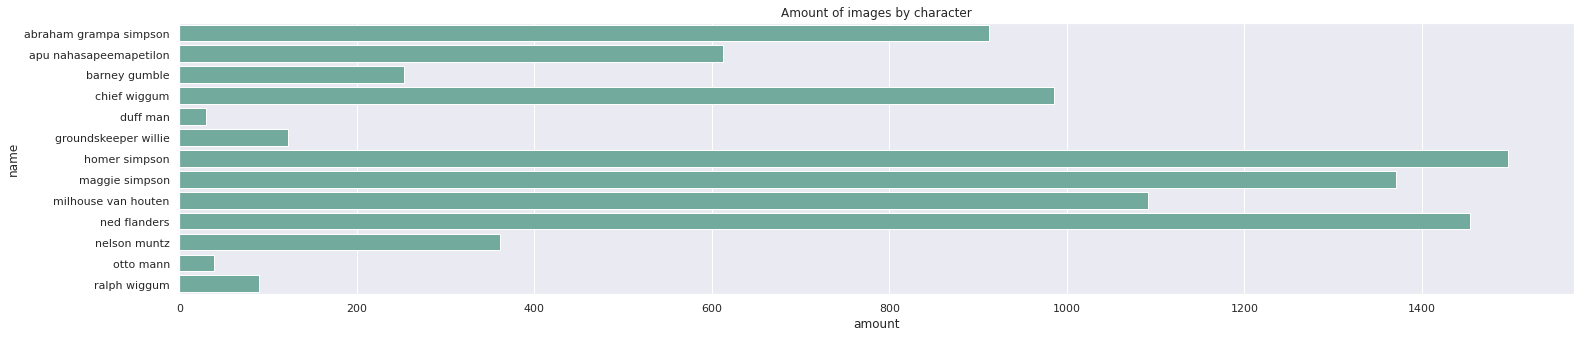

In [4]:
files = os.listdir(TRAINING_PATH + paths[6])
amount_delete = len(files) - 1497
files_to_delete = sample(files, amount_delete)

for fil in files_to_delete:
    os.remove(TRAINING_PATH + paths[6] + fil)

amount_images[6] = len(os.listdir(TRAINING_PATH + paths[6]))

data = {
    'name' : [' '.join(path.split('_')).replace('/', '') for path in paths],
    'amount' : amount_images
}

df = pd.DataFrame(data)

sns.set(style="darkgrid")
plt.figure(figsize=(25, 5))

sns.barplot(
    x = 'amount', 
    y = 'name', 
    data = df, 
    estimator = sum, 
    ci = None, 
    color = '#69b3a2').set_title('Amount of images by character');

Ahora veremos las diferentes dimensiones que tienen las imágenes y los diferentes formatos

Para el conjunto de entrenamiento

In [5]:
dimensions = []
extensions = []

for path in paths:
    pics = os.listdir(TRAINING_PATH + path)

    for pic in pics:
        image_dim = np.asarray(Image.open(TRAINING_PATH + path + pic)).shape
        
        if (len(image_dim) > 2):
            image_dim = image_dim[-1]
        
        else:
            image_dim = 2
        
        extension = pic.split('.')[-1]

    if (image_dim not in dimensions):
        dimensions.append(image_dim)
    
    if (extension not in extensions):
        extensions.append(extension)
  
    print('Done analyzing ' + path)

print('---------------------------------------------')
print('Different dimensions: ', dimensions)
print('Different formats: ', extensions)

Done analyzing abraham_grampa_simpson/
Done analyzing apu_nahasapeemapetilon/
Done analyzing barney_gumble/
Done analyzing chief_wiggum/
Done analyzing duff_man/
Done analyzing groundskeeper_willie/
Done analyzing homer_simpson/
Done analyzing maggie_simpson/
Done analyzing milhouse_van_houten/
Done analyzing ned_flanders/
Done analyzing nelson_muntz/
Done analyzing otto_mann/
Done analyzing ralph_wiggum/
---------------------------------------------
Different dimensions:  [3]
Different formats:  ['jpg']


Para el conjunto de prueba

In [6]:
dimensions = []
extensions = []

for path in paths:
    pics = os.listdir(TEST_PATH + path)

    for pic in pics:
        image_dim = np.asarray(Image.open(TEST_PATH + path + pic)).shape
        
        if (len(image_dim) > 2):
            image_dim = image_dim[-1]
        
        else:
            image_dim = 2
        
        extension = pic.split('.')[-1]

    if (image_dim not in dimensions):
        dimensions.append(image_dim)
    
    if (extension not in extensions):
        extensions.append(extension)
  
    print('Done analyzing ' + path)

print('---------------------------------------------')
print('Different dimensions: ', dimensions)
print('Different formats: ', extensions)

Done analyzing abraham_grampa_simpson/
Done analyzing apu_nahasapeemapetilon/
Done analyzing barney_gumble/
Done analyzing chief_wiggum/
Done analyzing duff_man/
Done analyzing groundskeeper_willie/
Done analyzing homer_simpson/
Done analyzing maggie_simpson/
Done analyzing milhouse_van_houten/
Done analyzing ned_flanders/
Done analyzing nelson_muntz/
Done analyzing otto_mann/
Done analyzing ralph_wiggum/
---------------------------------------------
Different dimensions:  [3]
Different formats:  ['jpg']


# Leyendo el conjunto de datos y aplicando pre procesamiento

In [7]:
# Taken from
# https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [8]:
def load_image(filename, path,training = True):
    if (training):        
        inimg = tf.cast(tf.image.decode_image(tf.io.read_file(TRAINING_PATH + path + filename)), tf.float32)[..., :3]/255            
  
    else:
        inimg = tf.cast(tf.image.decode_image(tf.io.read_file(TEST_PATH + path + filename)), tf.float32)[..., :3]/255

    inimg = tf.image.resize(inimg, (32, 32))    
    inimg = rgb2gray(inimg)
    inimg = inimg[..., np.newaxis]

    return inimg

In [9]:
X_train = []
y_train = []

X_test = []
y_test = []

paths = ['abraham_grampa_simpson/',
          'apu_nahasapeemapetilon/',
          'barney_gumble/',
          'chief_wiggum/',
          'duff_man/',
          'groundskeeper_willie/',
          'homer_simpson/',
          'maggie_simpson/',
          'milhouse_van_houten/',
          'ned_flanders/',
          'nelson_muntz/',
          'otto_mann/',
          'ralph_wiggum/']

# Training
for i in range(len(paths)):

    files = os.listdir(TRAINING_PATH + paths[i])

    for j in range(len(files)):
        X_train.append(load_image(files[j], paths[i]))
        
    y_train.extend(np.full(len(files), i))

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_train, y_train = shuffle(X_train, y_train)

# Testing
for i in range(len(paths)):

    files = os.listdir(TEST_PATH + paths[i])

    for j in range(len(files)):
        X_test.append(load_image(files[j], paths[i], training = False))
  
    y_test.extend(np.full(len(files), i))

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)
X_test, y_test = shuffle(X_test, y_test)

onehot_encoder = OneHotEncoder(sparse=False)
y_train = y_train.reshape(len(y_train), 1)
y_train_onehot = onehot_encoder.fit_transform(y_train)

y_test = y_test.reshape(len(y_test), 1)
y_test_onehot = onehot_encoder.fit_transform(y_test)

In [10]:
data = {'shapes': [np.asarray(inp).shape for inp in X_test]}

df = pd.DataFrame(data)
df.value_counts()

shapes     
(32, 32, 1)    942
dtype: int64

In [11]:
data = {'shapes': [np.asarray(inp).shape for inp in y_train_onehot]}

df = pd.DataFrame(data)
df.value_counts()

shapes
(13,)     8819
dtype: int64

In [12]:
data = {'shapes': [np.asarray(inp).shape for inp in y_test_onehot]}

df = pd.DataFrame(data)
df.value_counts()

shapes
(13,)     942
dtype: int64

In [273]:
class DNN_model(object):
    def __init__(self, n_classes=13):
        
        self.h1LW = tf.Variable(np.random.rand(7, 7, 1, 64) * 0.001,
                               name = 'hl1weights',
                               dtype = 'float32')
        
        self.h1LB = tf.Variable(np.random.rand(64) * 0.001,
                               name = 'hl1bias',
                               dtype = 'float32')
                
        self.h2LW = tf.Variable(np.random.rand(5, 5, 64, 32) * 0.001,
                               name = 'hl2weights',
                               dtype = 'float32')
        
        self.h2LB = tf.Variable(np.random.rand(32) * 0.001,
                               name = 'hl2bias',
                               dtype = 'float32')                
        
        self.h3LW = tf.Variable(np.random.rand(3, 3, 32, 16) * 0.001,
                               name = 'hl3weights',
                               dtype = 'float32')
        
        self.h3LB = tf.Variable(np.random.rand(16) * 0.001,
                               name = 'hl3bias',
                               dtype = 'float32')                
        
        self.h4LW = tf.Variable(np.random.rand(16, 16) * 0.001,
                               name = 'hl4weights',
                               dtype = 'float32')
        
        self.h4LB = tf.Variable(np.random.rand(16) * 0.001,
                               name = 'hl4bias',
                               dtype = 'float32')                
        
        self.outW = tf.Variable(np.random.rand(16, n_classes) * 0.001,
                                name="outweigths",
                                dtype="float32")
        
        self.outB = tf.Variable(np.random.rand(n_classes) * 0.001,
                                name="outbias",
                                dtype="float32")
        
        self.trainable_variables =[self.h1LW,self.h1LB,
                                   self.h2LW,self.h2LB,
                                   self.h3LW,self.h3LB,
                                   self.h4LW,self.h4LB,
                                   self.outW,self.outB]
        
    def __call__(self,x):
        
        x  = tf.cast(x, tf.float32)
        img = tf.reshape(x, shape = [-1, 32, 32, 1])
        
        l1 = tf.nn.conv2d(img, self.h1LW, strides = [1, 2, 2, 1], padding = 'SAME')
        l1 = tf.nn.dropout(l1, 0.43)
        l1 = tf.add(l1, self.h1LB)
        l1 = tf.nn.relu(l1)
        l1 = tf.nn.max_pool(l1, ksize = [1, 2, 2, 1], padding = 'SAME', strides = [1, 2, 2, 1])
        
        l2 = tf.nn.conv2d(l1, self.h2LW, strides = [1, 2, 2, 1], padding = 'SAME')
        l2 = tf.nn.dropout(l2, 0.43)
        l2 = tf.add(l2, self.h2LB)
        l2 = tf.nn.relu(l2)
        l2 = tf.nn.max_pool(l2, ksize = [1, 2, 2, 1], padding = 'SAME', strides = [1, 2, 2, 1])
        
        l3 = tf.nn.conv2d(l2, self.h3LW, strides = [1, 2, 2, 1], padding = 'SAME')
        l3 = tf.nn.dropout(l3, 0.43)
        l3 = tf.add(l3, self.h3LB)
        l3 = tf.nn.relu(l3)
                
        l4 = tf.reshape(l3, [-1, 16])
        l4 = tf.matmul(l4, self.h4LW)
        l4 = tf.add(l4, self.h4LB)
        l4 = tf.nn.relu(l4)
        
        output = tf.matmul(l4, self.outW) + self.outB

        return output

In [274]:
model = DNN_model()
model(X_train[:30])

<tf.Tensor: shape=(30, 13), dtype=float32, numpy=
array([[0.00097066, 0.00073024, 0.00063877, 0.0007183 , 0.00093253,
        0.00082484, 0.00061486, 0.00015439, 0.00061031, 0.00054602,
        0.00029272, 0.000518  , 0.00021719],
       [0.00097065, 0.00073022, 0.00063875, 0.00071829, 0.00093251,
        0.00082482, 0.00061484, 0.00015438, 0.00061029, 0.00054601,
        0.00029271, 0.00051798, 0.00021718],
       [0.00097067, 0.00073025, 0.00063877, 0.00071832, 0.00093254,
        0.00082484, 0.00061487, 0.0001544 , 0.00061032, 0.00054603,
        0.00029272, 0.00051801, 0.0002172 ],
       [0.00097068, 0.00073026, 0.00063878, 0.00071832, 0.00093255,
        0.00082485, 0.00061488, 0.00015441, 0.00061033, 0.00054604,
        0.00029273, 0.00051802, 0.00021721],
       [0.00097063, 0.00073019, 0.00063873, 0.00071826, 0.00093249,
        0.0008248 , 0.00061482, 0.00015435, 0.00061027, 0.00054598,
        0.00029269, 0.00051796, 0.00021716],
       [0.00097065, 0.00073023, 0.00063876, 0

In [275]:
optimizador = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

In [276]:
@tf.function
def train_step(model,tdata, labels):
    with tf.GradientTape() as tape:
        predictions = model(tdata)
        #calculo de una funcion de error
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, predictions))
   
    gradients = tape.gradient(loss, model.trainable_variables)
    capped_grads_and_vars = [(grad,model.trainable_variables[index]) for index, grad in enumerate(gradients)]
    optimizador.apply_gradients(capped_grads_and_vars)
    train_loss(loss)
    train_accuracy(labels, predictions)

In [277]:
@tf.function
def test_step(model, tdata, labels):
    predictions = model(tdata)
    t_loss =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, predictions))

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [278]:
def fitting(model,train_x,train_y,test_x,test_y,EPOCHS,N_batch,batch_size):
    for epoch in range(EPOCHS):
        i = 0
        while i + batch_size < len(train_x) or i + batch_size < batch_size * N_batch:
            start = i
            end = i + batch_size
            batch_x = train_x[start:end]
            batch_y = train_y[start:end]
            train_step(model,batch_x,batch_y)
            i += batch_size

        test_step(model,test_x,test_y)
        
        template = '----------------------------------------------\nEpoch: {}\nPerdida: {}\nExactitud: {}\nPerdida de prueba: {}\nExactitud de prueba: {}\n----------------------------------------------\n'
        
        print(template.format(epoch+1,
                              train_loss.result(),
                              train_accuracy.result()*100,
                              test_loss.result(),
                              test_accuracy.result()*100))
        
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

In [279]:
fitting(model, X_train, y_train_onehot, X_test, y_test_onehot, 400, 32, 32)

----------------------------------------------
Epoch: 1
Perdida: 2.20868182182312
Exactitud: 16.43181800842285
Perdida de prueba: 2.3442881107330322
Exactitud de prueba: 32.27176284790039
----------------------------------------------

----------------------------------------------
Epoch: 2
Perdida: 2.166524887084961
Exactitud: 17.602272033691406
Perdida de prueba: 2.2989842891693115
Exactitud de prueba: 32.3779182434082
----------------------------------------------

----------------------------------------------
Epoch: 3
Perdida: 2.139235734939575
Exactitud: 21.56818199157715
Perdida de prueba: 2.222585678100586
Exactitud de prueba: 33.014862060546875
----------------------------------------------

----------------------------------------------
Epoch: 4
Perdida: 2.0823051929473877
Exactitud: 24.69318199157715
Perdida de prueba: 2.0823636054992676
Exactitud de prueba: 33.227176666259766
----------------------------------------------

----------------------------------------------
Epoc

----------------------------------------------
Epoch: 36
Perdida: 1.5751726627349854
Exactitud: 45.897727966308594
Perdida de prueba: 1.9708853960037231
Exactitud de prueba: 42.78131866455078
----------------------------------------------

----------------------------------------------
Epoch: 37
Perdida: 1.5491582155227661
Exactitud: 46.15909194946289
Perdida de prueba: 1.7837458848953247
Exactitud de prueba: 47.133758544921875
----------------------------------------------

----------------------------------------------
Epoch: 38
Perdida: 1.5489915609359741
Exactitud: 46.90909194946289
Perdida de prueba: 1.9199432134628296
Exactitud de prueba: 42.14437484741211
----------------------------------------------

----------------------------------------------
Epoch: 39
Perdida: 1.5521297454833984
Exactitud: 46.522727966308594
Perdida de prueba: 1.9109216928482056
Exactitud de prueba: 43.312103271484375
----------------------------------------------

----------------------------------------

----------------------------------------------
Epoch: 71
Perdida: 1.3618011474609375
Exactitud: 54.147727966308594
Perdida de prueba: 1.7668685913085938
Exactitud de prueba: 53.60934066772461
----------------------------------------------

----------------------------------------------
Epoch: 72
Perdida: 1.3581476211547852
Exactitud: 54.102272033691406
Perdida de prueba: 1.7339473962783813
Exactitud de prueba: 54.67091369628906
----------------------------------------------

----------------------------------------------
Epoch: 73
Perdida: 1.340889573097229
Exactitud: 55.39772415161133
Perdida de prueba: 1.8049131631851196
Exactitud de prueba: 53.078556060791016
----------------------------------------------

----------------------------------------------
Epoch: 74
Perdida: 1.3503497838974
Exactitud: 54.89772415161133
Perdida de prueba: 1.8529243469238281
Exactitud de prueba: 51.80467224121094
----------------------------------------------

---------------------------------------------

----------------------------------------------
Epoch: 106
Perdida: 1.2672895193099976
Exactitud: 57.965911865234375
Perdida de prueba: 1.7461116313934326
Exactitud de prueba: 55.30785369873047
----------------------------------------------

----------------------------------------------
Epoch: 107
Perdida: 1.2366282939910889
Exactitud: 58.71590805053711
Perdida de prueba: 1.869291067123413
Exactitud de prueba: 54.45859909057617
----------------------------------------------

----------------------------------------------
Epoch: 108
Perdida: 1.2517553567886353
Exactitud: 58.29545211791992
Perdida de prueba: 1.769719123840332
Exactitud de prueba: 52.3354606628418
----------------------------------------------

----------------------------------------------
Epoch: 109
Perdida: 1.2505987882614136
Exactitud: 58.499996185302734
Perdida de prueba: 1.8350613117218018
Exactitud de prueba: 54.564754486083984
----------------------------------------------

----------------------------------------

----------------------------------------------
Epoch: 141
Perdida: 1.1901408433914185
Exactitud: 61.102272033691406
Perdida de prueba: 1.662168025970459
Exactitud de prueba: 56.79405212402344
----------------------------------------------

----------------------------------------------
Epoch: 142
Perdida: 1.1851544380187988
Exactitud: 61.352272033691406
Perdida de prueba: 1.6809563636779785
Exactitud de prueba: 58.811038970947266
----------------------------------------------

----------------------------------------------
Epoch: 143
Perdida: 1.1841970682144165
Exactitud: 61.4886360168457
Perdida de prueba: 1.6963379383087158
Exactitud de prueba: 56.687896728515625
----------------------------------------------

----------------------------------------------
Epoch: 144
Perdida: 1.1796646118164062
Exactitud: 61.64772415161133
Perdida de prueba: 1.6369050741195679
Exactitud de prueba: 58.06793975830078
----------------------------------------------

--------------------------------------

----------------------------------------------
Epoch: 176
Perdida: 1.1389657258987427
Exactitud: 63.20454406738281
Perdida de prueba: 1.6538598537445068
Exactitud de prueba: 58.59872817993164
----------------------------------------------

----------------------------------------------
Epoch: 177
Perdida: 1.13148832321167
Exactitud: 62.68181610107422
Perdida de prueba: 1.7573343515396118
Exactitud de prueba: 57.112525939941406
----------------------------------------------

----------------------------------------------
Epoch: 178
Perdida: 1.1432344913482666
Exactitud: 62.727272033691406
Perdida de prueba: 1.7246540784835815
Exactitud de prueba: 56.4755859375
----------------------------------------------

----------------------------------------------
Epoch: 179
Perdida: 1.149314045906067
Exactitud: 62.57954788208008
Perdida de prueba: 1.7926853895187378
Exactitud de prueba: 54.777069091796875
----------------------------------------------

--------------------------------------------

----------------------------------------------
Epoch: 211
Perdida: 1.1017441749572754
Exactitud: 64.1022720336914
Perdida de prueba: 1.6731160879135132
Exactitud de prueba: 57.85562515258789
----------------------------------------------

----------------------------------------------
Epoch: 212
Perdida: 1.0902020931243896
Exactitud: 64.84090423583984
Perdida de prueba: 1.9218720197677612
Exactitud de prueba: 54.777069091796875
----------------------------------------------

----------------------------------------------
Epoch: 213
Perdida: 1.081784725189209
Exactitud: 64.06818389892578
Perdida de prueba: 1.6928739547729492
Exactitud de prueba: 57.85562515258789
----------------------------------------------

----------------------------------------------
Epoch: 214
Perdida: 1.1016656160354614
Exactitud: 64.71591186523438
Perdida de prueba: 1.6189497709274292
Exactitud de prueba: 60.6157112121582
----------------------------------------------

------------------------------------------

----------------------------------------------
Epoch: 246
Perdida: 1.0864660739898682
Exactitud: 64.63636016845703
Perdida de prueba: 1.7707664966583252
Exactitud de prueba: 58.59872817993164
----------------------------------------------

----------------------------------------------
Epoch: 247
Perdida: 1.0674563646316528
Exactitud: 65.78408813476562
Perdida de prueba: 1.8236335515975952
Exactitud de prueba: 55.201698303222656
----------------------------------------------

----------------------------------------------
Epoch: 248
Perdida: 1.0494576692581177
Exactitud: 66.1477279663086
Perdida de prueba: 1.846580147743225
Exactitud de prueba: 54.88322830200195
----------------------------------------------

----------------------------------------------
Epoch: 249
Perdida: 1.0587289333343506
Exactitud: 65.7727279663086
Perdida de prueba: 1.6789278984069824
Exactitud de prueba: 58.59872817993164
----------------------------------------------

------------------------------------------

----------------------------------------------
Epoch: 281
Perdida: 1.0439714193344116
Exactitud: 66.53408813476562
Perdida de prueba: 1.6590101718902588
Exactitud de prueba: 59.23566818237305
----------------------------------------------

----------------------------------------------
Epoch: 282
Perdida: 1.0587564706802368
Exactitud: 65.69318389892578
Perdida de prueba: 1.721628189086914
Exactitud de prueba: 57.96178436279297
----------------------------------------------

----------------------------------------------
Epoch: 283
Perdida: 1.0435348749160767
Exactitud: 66.05681610107422
Perdida de prueba: 1.7987416982650757
Exactitud de prueba: 57.21868133544922
----------------------------------------------

----------------------------------------------
Epoch: 284
Perdida: 1.043420433998108
Exactitud: 66.19318389892578
Perdida de prueba: 1.9935834407806396
Exactitud de prueba: 57.006370544433594
----------------------------------------------

-----------------------------------------

----------------------------------------------
Epoch: 316
Perdida: 1.034014344215393
Exactitud: 66.875
Perdida de prueba: 1.7332736253738403
Exactitud de prueba: 56.687896728515625
----------------------------------------------

----------------------------------------------
Epoch: 317
Perdida: 1.021786093711853
Exactitud: 67.20454406738281
Perdida de prueba: 1.6544854640960693
Exactitud de prueba: 58.59872817993164
----------------------------------------------

----------------------------------------------
Epoch: 318
Perdida: 1.0140801668167114
Exactitud: 66.84091186523438
Perdida de prueba: 1.74526047706604
Exactitud de prueba: 57.74946975708008
----------------------------------------------

----------------------------------------------
Epoch: 319
Perdida: 1.0103453397750854
Exactitud: 67.5
Perdida de prueba: 1.6296625137329102
Exactitud de prueba: 58.17409896850586
----------------------------------------------

----------------------------------------------
Epoch: 320
Perdida: 

----------------------------------------------
Epoch: 351
Perdida: 1.0197006464004517
Exactitud: 67.63636779785156
Perdida de prueba: 1.7085703611373901
Exactitud de prueba: 57.006370544433594
----------------------------------------------

----------------------------------------------
Epoch: 352
Perdida: 1.0058668851852417
Exactitud: 67.65908813476562
Perdida de prueba: 1.8081649541854858
Exactitud de prueba: 57.430999755859375
----------------------------------------------

----------------------------------------------
Epoch: 353
Perdida: 1.014257550239563
Exactitud: 66.69318389892578
Perdida de prueba: 1.8631198406219482
Exactitud de prueba: 54.88322830200195
----------------------------------------------

----------------------------------------------
Epoch: 354
Perdida: 1.0060492753982544
Exactitud: 67.53408813476562
Perdida de prueba: 1.7139467000961304
Exactitud de prueba: 59.129512786865234
----------------------------------------------

--------------------------------------

KeyboardInterrupt: 